In [1]:
import numpy as np
import os, sys
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["KMP_WARNINGS"] = "FALSE" 
import time
# Import hessianlearn repository
sys.path.append( os.environ.get('HESSIANLEARN_PATH', "../../"))
from hessianlearn import *

sys.path.append('../hessianlearn/algorithms')
from varianceBasedNystrom import *
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
settings = {}
settings['batch_size'] = 100
settings['hess_batch_size'] = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Reshape the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Instante the data object
data = Data([x_train,y_train],settings['batch_size'],\
            test_data = [x_test,y_test],hessian_batch_size = settings['hess_batch_size'])

In [3]:
encoding_dim = 32  
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='softplus')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
problem = AutoencoderProblem(autoencoder,dtype=tf.float32)

settings['tikhonov_gamma'] = 0.0

regularization = L2Regularization(problem,gamma = settings['tikhonov_gamma'])

In [5]:
def compute_Theta_slow(Q, apply_AA):
    r = Q.shape[1]
    m = len(apply_AA)
    Theta_true = np.zeros((r, r, m))
    for i in range(r):
        for j in range(r):
            for k in range(m):
                Theta_true[i,j,k] = np.dot(Q[:,i], apply_AA[k](Q[:,j]))
    return Theta_true

def compute_rayleigh_statistics_slow(U, apply_AA):
    m = len(apply_AA)
    r = U.shape[1]
    C = np.zeros((r, m))
    for k in range(m):
        for i in range(r):
            C[i,k] = np.dot(U[:,i], apply_AA[k](U[:,i]))

    all_mu = np.mean(C, axis=1)
    all_std = np.std(C, axis=1)
    return all_mu, all_std

92.00505
w_hat.shape =  (50992,)
||w_hat|| =  225.07497834479076
||Hw_hat|| =  0.20873709
current_rank= 5 , num_bad_vectors= 0
current_rank= 15 , num_bad_vectors= 0
current_rank= 25 , num_bad_vectors= 0
current_rank= 35 , num_bad_vectors= 0
current_rank= 45 , num_bad_vectors= 0
current_rank= 55 , num_bad_vectors= 0
current_rank= 65 , num_bad_vectors= 0
current_rank= 75 , num_bad_vectors= 0
current_rank= 85 , num_bad_vectors= 0
current_rank= 95 , num_bad_vectors= 0
current_rank= 105 , num_bad_vectors= 0


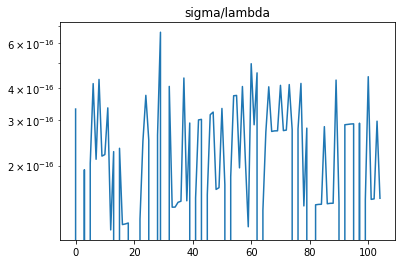

In [6]:
with tf.Session() as sess:
    random_state = np.random.RandomState(seed=0)
    
    sess.run(tf.global_variables_initializer())
    
    hessian = Hessian(problem = problem,sess = sess)
    n = hessian.dimension
    x_batch,_ = next(data.train)
    
    x_data = x_batch[0:100]

    print(np.linalg.norm(x_data))
    
    w_hat = random_state.randn(hessian.dimension)
    print('w_hat.shape = ',w_hat.shape)
    feed_dict = {problem.x : x_data}
    
    Hw_hat = hessian(w_hat,feed_dict)
    print('||w_hat|| = ',np.linalg.norm(w_hat))
    print('||Hw_hat|| = ',np.linalg.norm(Hw_hat))
    
    data_dictionaries = [{problem.x : np.expand_dims(x_datum,axis=0)} for x_datum in x_data]
    apply_AA = [lambda x: hessian(x,dictionary) for dictionary in data_dictionaries]

    if False:
        batch_r = 10
        Y = get_random_range_vectors(apply_AA, n, batch_r)

        Q,_ = np.linalg.qr(Y)
        Theta = compute_Theta(Q, apply_AA)
        print('Theta shape = ',Theta.shape)

        Theta_true = compute_Theta_slow(Q, apply_AA)
        err_Theta = np.linalg.norm(Theta - Theta_true)/np.linalg.norm(Theta_true)
        print('err_Theta=', err_Theta)
        dd, U, V = finish_computing_eigenvalue_decomposition(Q, Theta)

        all_mu, all_std = compute_rayleigh_statistics(Theta, V)

        all_mu_true, all_std_true = compute_rayleigh_statistics_slow(U, apply_AA)

        err_mu = np.linalg.norm(all_mu - all_mu_true)/np.linalg.norm(all_mu_true)
        err_std = np.linalg.norm(all_std - all_std_true)/np.linalg.norm(all_std_true)

        print('all_std = ',all_std)
        print('all_std_true = ',all_std_true)

        print('err_mu=', err_mu)
        print('err_std=', err_std)

    
    dd_good, U_good, all_std_good = variance_based_nystrom(apply_AA, n)
    plt.semilogy(all_std_good/np.abs(dd_good))
    plt.title('sigma/lambda')
    